# Ridge Regression & Lasso

## Goals of the lab:
* Learn to use the `glmnet` function.
* Understand that hyperparameter selection should also be validated.

This lab draws from the practice sets at the end of Chapter 6 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

---
# Ridge Regression

In this tutorial, we'll dive a little deeper into ridge regression and LASSO. For this we will load the [Hitters (baseball) dataset](https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Hitters.html) included in ISLR.

Ridge regression is made easy with the [`glmnet` package](https://cran.r-project.org/web/packages/glmnet/glmnet.pdf), so we'll install that to start.

In [ ]:
# install.packages("ISLR") # uncomment if you haven't installed this library
library(ISLR)
names(Hitters)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "AtBat"     "Hits"      "HmRun"     "Runs"      "RBI"       "Walks"    
 [7] "Years"     "CAtBat"    "CHits"     "CHmRun"    "CRuns"     "CRBI"     
[13] "CWalks"    "League"    "Division"  "PutOuts"   "Assists"   "Errors"   
[19] "Salary"    "NewLeague"

In [ ]:
# install.packages("glmnet", dependencies = TRUE) # uncomment if you haven't installed this library
library(glmnet)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘lars’


Loading required package: Matrix

Loaded glmnet 4.1-1



Remember that, for ridge regression, you need to find the best tuning parameter ($\lambda$) to use. This tuning parameter determines the sparsity of the model, or the impact of each predictor, using the L2 norm. This contrasts with LASSO, which conducts *feature selection* using the L1 norm. In both cases, the larger the $\lambda$ value, the more pressure there is on the $\beta$ coefficients to become very small (ridge regression) or to become 0 (LASSO). 

Let's start by establishing the range of $\lambda$ values we'll be considering.

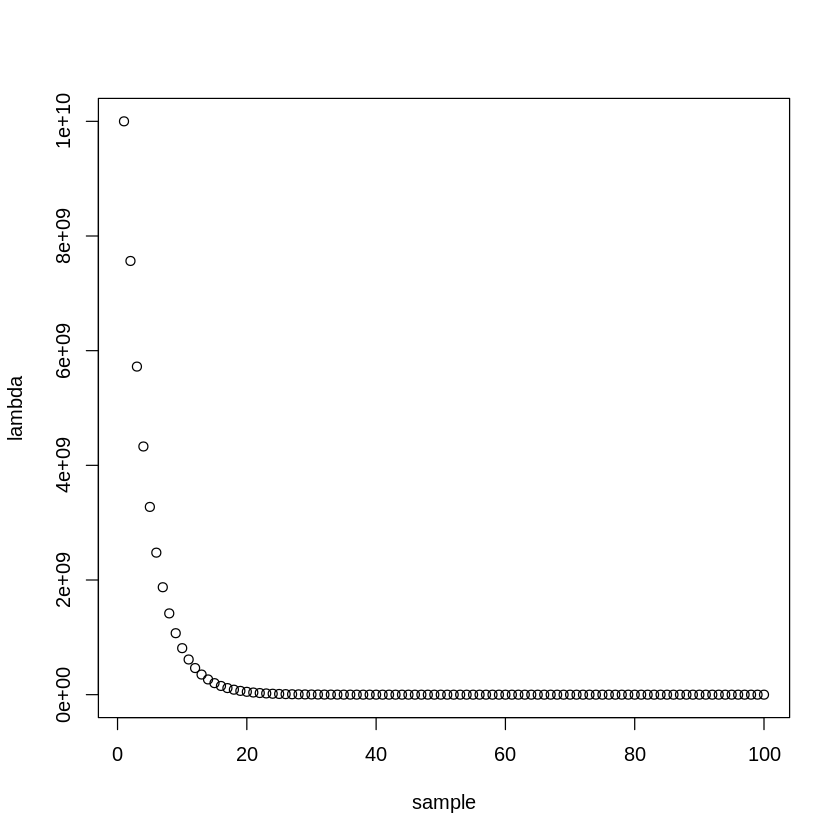

In [ ]:
# Use a non-linear search on lambda
lambda_search_space = 10^seq(10, -2, length=100) #create a search space from (10^10):(10^-2), 100 samples long
plot(lambda_search_space, xlab="sample", ylab="lambda")

#this will span a range of models, from the null model containing only the intercept (lambda = 10^10, extremely sparse)
#to the least squares fit (lambda = 0, lenient)

The `glmnet` package requires that you use matrices instead of dataframes, and that x and y are specified separately. So let's select x and y. 

In [ ]:
# Define x without the first column
x = model.matrix(Salary~., Hitters)[,-1] #without first intercept column
#the model.matrix function also automatically transforms qualitative variables
#into dummy variables and gets rid of NAs

y = Hitters$Salary[!(is.na(Hitters$Salary))] #selecting y from the dataframe - get rid of NAs so that rows are matched with those in x

Now, technically you are using an *elastic net* algorithm when using the `glmnet` function. So we have to set $\alpha$ to zero in order to run pure ridge regression. If $\alpha$ is 0, then a ridge regression model is fit, and if $\alpha$ is 1, then a LASSO model is fit.

In [ ]:
ridge.mod = glmnet(x, y, alpha=0, lambda=lambda_search_space)

Ridge regression returns all _p_ variables for each value of $\lambda$. Thus we get a matrix of regression coefficients instead of a vector.

In [ ]:
dim(coef(ridge.mod)) #this gives 20 rows (one for each predictor, plus a new intercept)
#and 100 columns, one for each value of lambda in the search space

[1]  20 100

Let's look at all 20 coefficients (including the intercept) when $\lambda = 11497.57$ (i.e., the 50th entry in the $\lambda$ vector)

[1] 11497.57

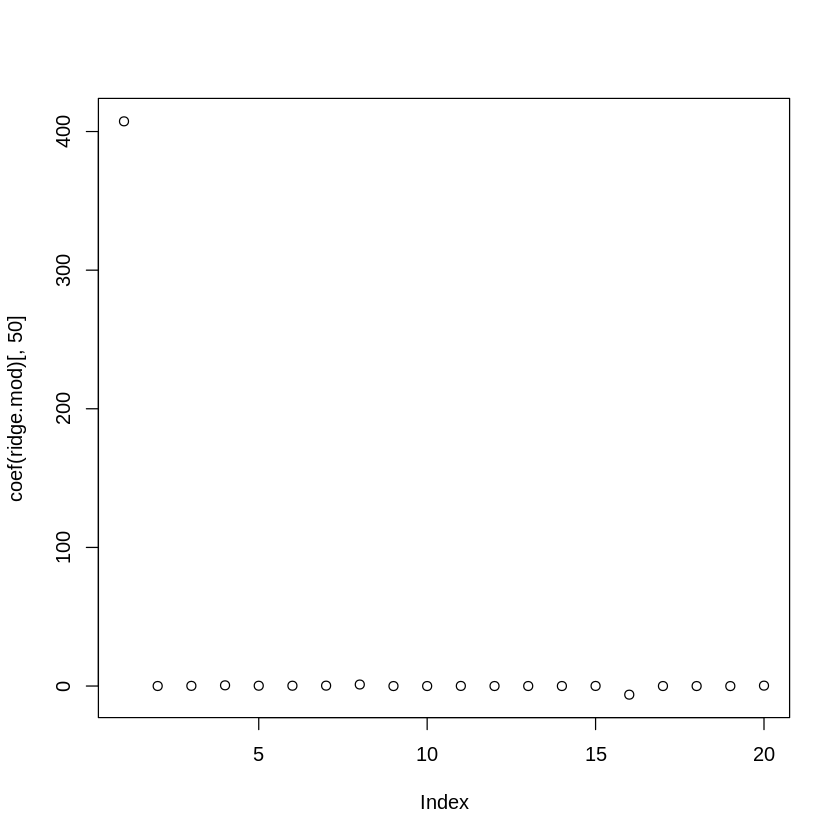

In [ ]:
lambda_search_space[50] #getting particular value of lambda
plot(coef(ridge.mod)[,50]) #getting coeff. for that value of lamba, all coeff.

Here you can see that many of them are near zero in value while a few terms retain strong, non-zero values. 

Now what happens if we make $\lambda$ really *really* large?

[1] 5722367659

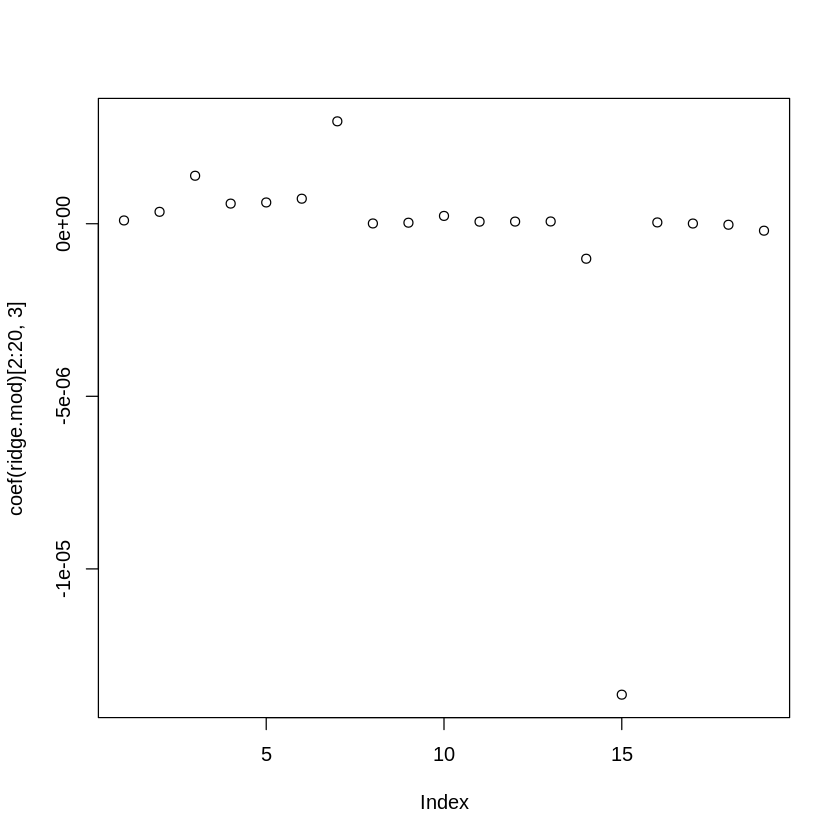

In [ ]:
lambda_search_space[3]
plot(coef(ridge.mod)[2:20,3])

Notice a difference between when $\lambda = 11498$ and when $\lambda = 5722367659$? 

The coefficients are much smaller. The larger the value of $\lambda$, the more sparse the model. In other words, as $\lambda$ increases, the flexibility of the fit *decreases*. This decreases the variance of the model and increases bias. 

You can test any value of $\lambda$ using the `predict()` function.

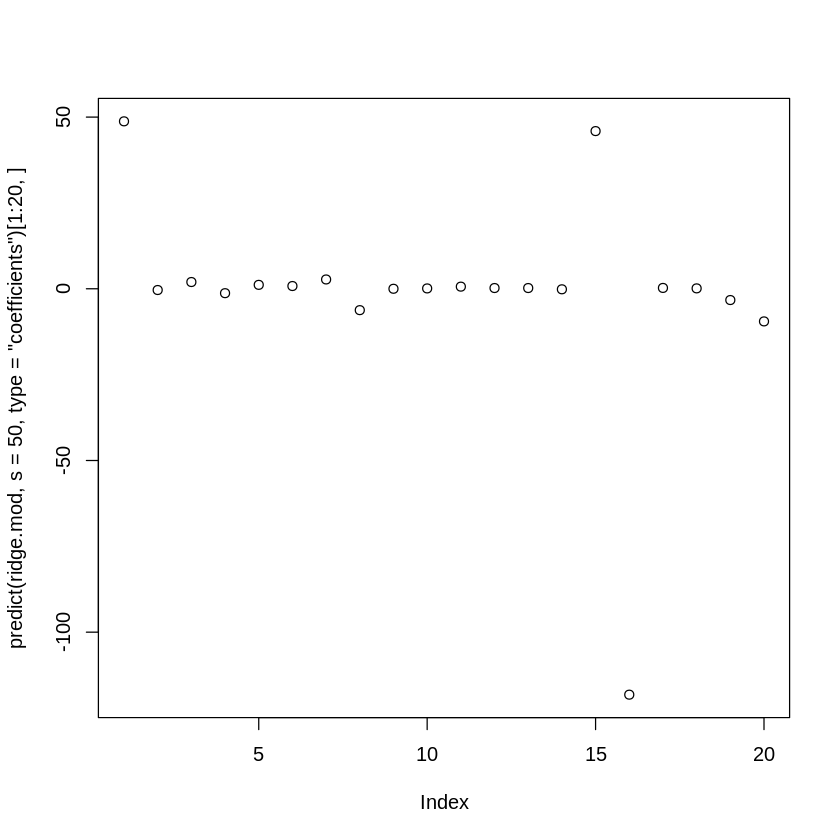

In [ ]:
plot(predict(ridge.mod, s=50, type="coefficients")[1:20,]) #s=lambda=50

Let's create a simple 50/50 split for the training and test set for the ridge regression. 

In [ ]:
set.seed(1) # Use the same seed so we get the same results

# Create your validation sets
train=sample(1:nrow(x), nrow(x)/2) #50/50 split into training and test sets
test=(-train) #get test indices (not training indices)
y.test = y[test]

# Make a training model using the training set (for all values of lambda)
ridge.mod = glmnet(x[train,], y[train], alpha=0, lambda=lambda_search_space, thresh=1e-12) #threshold specifies the convergence criterion

Let's now test different fits using different $\lambda$.

In [ ]:
# With lambda = 1e10 (10^10)
#note that this is like a null, intercept-only model
ridge.pred = predict(ridge.mod, s=1e10, newx=x[test,])
mean((ridge.pred - y.test)^2)

# With lambda = 4 (s=lambda)
ridge.pred = predict(ridge.mod, s=4, newx=x[test,])
mean((ridge.pred - y.test)^2)

# With lambda = 0 (note that this is OLS regression)
ridge.pred = predict(ridge.mod, s=0, newx=x[test,])
mean((ridge.pred - y.test)^2)

[1] 224669.8

[1] 142199.2

[1] 167789.8

When $\lambda$ was large, the MSE was worse than OLS. When it's smaller (but not 0), it improves upon the OLS MSE. Hence we need to maximize the bias-variance tradeoff.

# An important note about validation and test sets

Remember, if we want to test the predictive utility of a model, it's important to separate estimates from training and test data. We did this above at a basic level, for the glm regression variables. But this separation should also include the model and variable selection step (i.e., in this context, $\lambda$). 
So, the determination of which model is best must be made using training and test observations separate from the estimation of the general linear model. If we use the same data to perform best subset selection as we do to estimate and/or test our final model, then the estimate of test error will be contaminated. 

**Note: You will need sufficient power to split your data into the required number of training and validation sets.** 

Here, we need to use a separate training and validation set to find and test the best $\lambda$. Let's find the best $\lambda$ using 10-fold cross-validation.

In [ ]:
set.seed(2) # Use the same seed so we get the same results

# Create your validation sets
train=sample(1:nrow(x), nrow(x)/2) #50/50 split into training and test sets
test=(-train) #get test indices (not training indices)

#split each of the training and test phases into two 
#need to have separate validation sets for lambda and for beta estimates

train_hyperparameter = sample(train, length(train)/2)
train_glm = (-train_hyperparameter)

test_hyperparameter = sample(test, length(test)/2)
test_glm = (-test_hyperparameter)

#make sure that the samples do not overlap
sum(test_hyperparameter == train_hyperparameter) 
sum(test_glm == train_glm) 
sum(train_hyperparameter == train_glm) 

[1] 0

[1] 0

[1] 0

[1] 135.1456

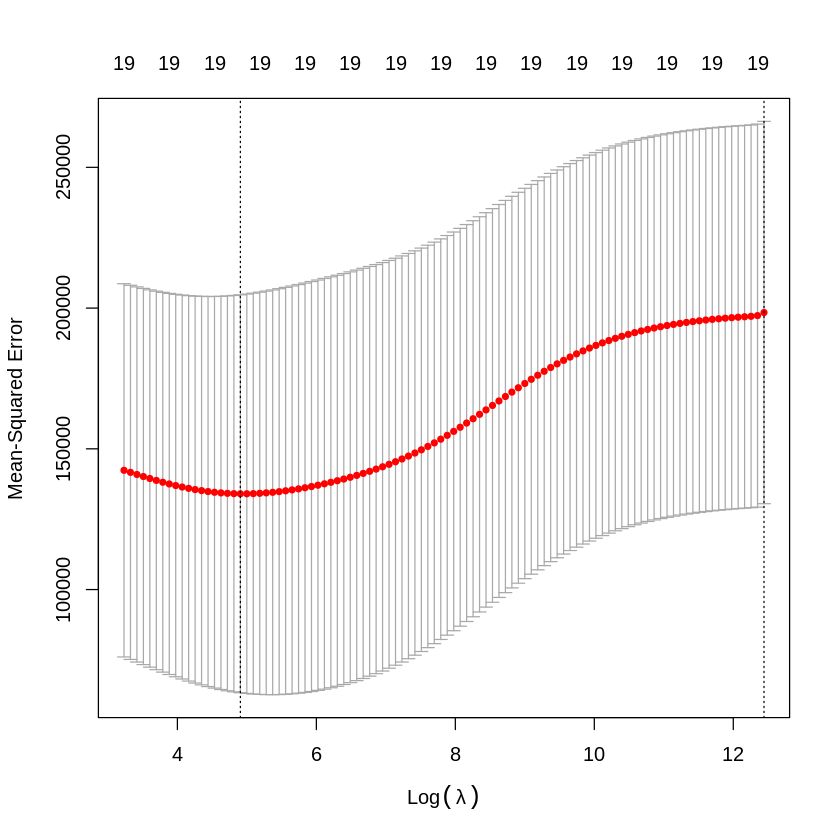

In [ ]:
# Using 10-fold CV, cross-validate on the training data
set.seed(1)
cv.out = cv.glmnet(x[train_hyperparameter,], y[train_hyperparameter], alpha=0) #alpha=0=ridge regression
plot(cv.out) #defaults to 10-fold CV
bestlam = cv.out$lambda.min
bestlam

The $\lambda$ with the lowest cross-validation MSE is $\lambda = 390.75$. We can use this value of $\lambda$ to look at our hold-out test accuracy.

In [ ]:
#passing in the trained model object, the best lambda, and the test data
ridge.pred = predict(ridge.mod, s=bestlam, newx=x[test_hyperparameter,]) 
mean((ridge.pred -y[test_hyperparameter])^2) #MSE

[1] 119507.5

Using this best lambda, we can also get the actual regression coefficients for all 20 parameters in the model (including the intercept). Here, we refit the ridge regression model on the training dataset dedicated for this purpose (`train_glm`) and then look at coefficient predictions for the `test_glm` dataset. 

In [ ]:
# First setup the model
out = glmnet(x[train_glm,],y[train_glm], alpha=0)

# # Then predict.
print(predict(out, type="coefficients", s=bestlam, newx=x[test_glm,])[1:20,]) # "s = bestlam" picks out the winning value and shows those coefs.

  (Intercept)         AtBat          Hits         HmRun          Runs 
-38.812546181   0.007535828   1.517425980  -4.090339763   1.407753980 
          RBI         Walks         Years        CAtBat         CHits 
  1.037274878   2.172859070  -3.143396736   0.014712552   0.109118248 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
  0.177487099   0.183558581   0.171052370  -0.023204448  10.742320818 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-88.771290300   0.234770575  -0.035088669  -1.551198110  -7.358141646 


---
# LASSO

In order to run LASSO, you repeat the same steps as shown in the example above but replace alpha=0 with alpha=1. Try re-running the cells above with LASSO instead of ridge regression and see how it changes!

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, Patience Stevens, and Amy Sentis.*